# Signal flow

The following is some derivation of the "signal flow" calculation for a directed network used in _Varshney et al. 2011_ [1], as well as my own implementation and some simple simulations to attempt to understand this function better.

Feedback welcome!

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_context('talk')

### Problem statement
Given a directed graph, represented by adjacency matrix $A$, we are interested in understanding the feedforward structure of the graph. 

For example, in the case of a connectome, we would like to quantify the 

 - How "high" is an individual neuron in the sensory $\rightarrow$ motor pathway?
 - To what extent can the entire graph be thought of as feedforward pathway?

For now, we will focus on the first of these questions. We seek a vector $z \in \mathbb{R}^n$ such that nodes which are "high" in the feedforward structure of the graph have a high $z_i$ associated with node $i$. We will call this value $z_i$ the signal flow for node $i$. 

### Notation
$A \in \mathbb{R}^{n \times n}$: a (possibly weighted), loopless adjacency matrix representing a graph with a single connected component

$W \in \mathbb{R}^{n \times n}$: $\frac{A + A^T}{2}$, the symmetrized adjacency matrix

$\Delta \in \mathbb{R}^{n \times n}$: an antisymmetric matrix, which we will specify later

$z \in \mathbb{R}^{n}$: the vector of signal flows for each node $\{1, 2, ... ,n\}$

### Generating some data
Here we create a perfect feedforward network, where all nodes in a block project to the "next" block

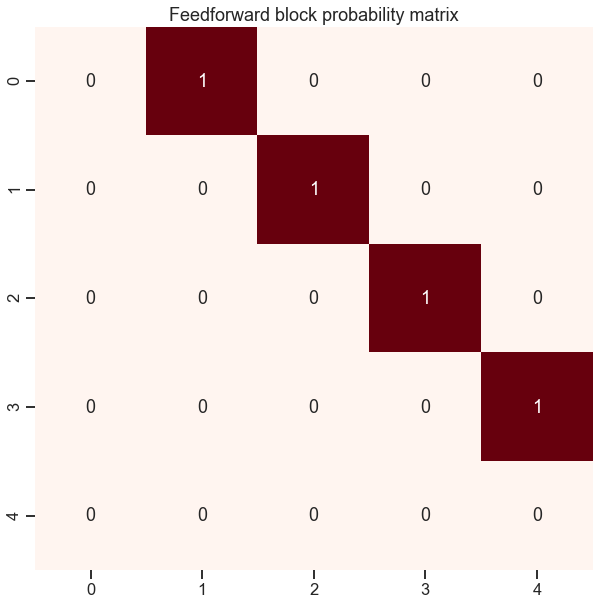

In [2]:
low_p = 0 # probability of random edges anywhere in the graph
diag_p = 0 # probability of edges within a block
feedforward_p = 1 # probability of edges projecting to the next block
n_blocks = 5
n_per_block = 50
block_sizes = n_blocks*[n_per_block]
n_verts = sum(block_sizes)

def get_feedforward_B(low_p, diag_p, feedforward_p, n_blocks=5):
    B = np.zeros((n_blocks, n_blocks))
    B += low_p
    B -= np.diag(np.diag(B))
    B -= np.diag(np.diag(B, k=1), k=1)
    B += np.diag(diag_p * np.ones(n_blocks))
    B += np.diag(feedforward_p * np.ones(n_blocks - 1), k=1)
    return B

def get_block_labels(n):
    n = np.array(n)
    n_cumsum = n.cumsum()
    labels = np.zeros(n.sum(), dtype=np.int64)
    for i in range(1, len(n)):
        labels[n_cumsum[i - 1] : n_cumsum[i]] = i
    return labels

block_probs = get_feedforward_B(low_p,
                                diag_p,
                                feedforward_p,
                                n_blocks=n_blocks)
block_labels = get_block_labels(block_sizes)

plt.figure(figsize=(10, 10))
sns.heatmap(block_probs, annot=True, cmap="Reds", cbar=False)
plt.title("Feedforward block probability matrix");

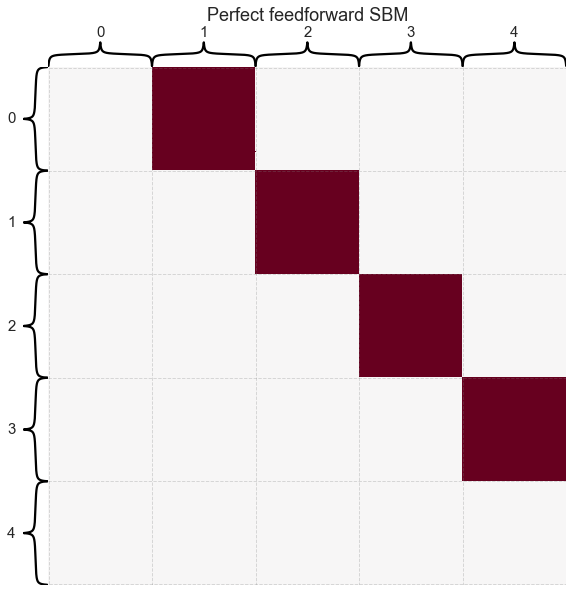

In [3]:
from graspy.simulations import sbm
from graspy.plot import heatmap

A = sbm(block_sizes, block_probs, directed=True, loops=False)

heatmap(A,
        cbar=False,
        title="Perfect feedforward SBM",
        inner_hier_labels=block_labels, 
        hier_label_fontsize=15);

_NB:_ If you had been handed a shuffled adjacency matrix, it would be hard to tell it's feedforward:

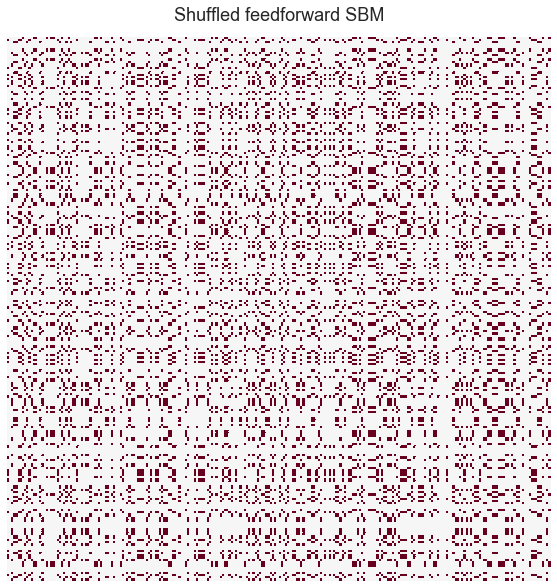

In [4]:
shuffle_inds = np.random.permutation(n_verts)
heatmap(A[np.ix_(shuffle_inds, shuffle_inds)],
        cbar=False,
        title="Shuffled feedforward SBM");

### Defining an energy (objective) function
Define the energy function

$$E(z) = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j - \delta_{ij})^2$$

$$E(z) = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j)^2 - \sum_{i, j = 1}^n w_{ij} \delta_{ij} (z_i - z_j) + \frac{1}{2} \sum_{i, j = 1}^n w_{ij} x_{ij}^2$$

Let $E_0 = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} x_{ij}^2$

Note that $\frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j)^2$ is related to the unnormalized graph laplacian: $L = D - W$

$$\frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j)^2$$

$$\frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i^2 - 2z_i z_j - z_j^2)$$

Let $d_i = \sum_{j = 1}^n w_{ij}$, the degree of node $i$. Since $W$ is symmetric

$$\frac{1}{2} \sum_{i = 1}^n d_i z_i^2 - \sum_{i, j = 1}^n w_{ij} z_i z_j + \frac{1}{2} \sum_{j = 1}^n d_j z_j^2$$

$$\frac{1}{2} \sum_{i = 1}^n d_i z_i^2 - \sum_{i, j = 1}^n w_{ij} z_i z_j + \frac{1}{2} \sum_{j = 1}^n d_j z_j^2$$

$$\sum_{i = 1}^n d_i z_i^2 - \sum_{i, j = 1}^n w_{ij} z_i z_j$$

$$z^T D z - z^T W z$$

$$z^T (D - W) z$$

$$z^T L z$$

Now, consider the term 

$$\sum_{i, j = 1}^n w_{ij} \delta_{ij} (z_i - z_j)$$

$$\sum_{i, j = 1}^n w_{ij} \delta_{ij} z_i  -  \sum_{i, j = 1}^n w_{ij} \delta_{ij}z_j$$

$$\sum_{i, j = 1}^n w_{ji}( - \delta_{ji}) z_i  -  \sum_{i, j = 1}^n w_{ij} \delta_{ij}z_j$$

$$\sum_{i, j = 1}^n w_{ji}( - \delta_{ji}) z_i  -  \sum_{i, j = 1}^n w_{ij} \delta_{ij}z_j$$

define $b_i = \sum_{j=1}^n w_{ij}x_{ij}$. Now the above reduces to

$$-z^Tb - z^Tb = -2z^Tb$$. 

$$E(z) = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j)^2 - \sum_{i, j = 1}^n w_{ij} \delta_{ij} (z_i - z_j) + \frac{1}{2} \sum_{i, j = 1}^n w_{ij} x_{ij}^2 = z^T L z - 2z^T b + E_0$$

where $E_0$ is the remaining constant (which does not depend on $z$). 

### Solving for $z$

Taking the derivative of $E(z)$, 

$$\frac{dE(z)}{dz} = \frac{d}{dz} (z^T L z - 2z^T b + E_0) =  2 L z - 2 b$$

Setting equal to 0, 

$$L z = b$$

$L$ is singular. To see this, recall that 

$$Lx = (D - W)x$$

Let $x$ be the vector of all ones, then 

$$(Dx - Wx)_i = d_i - \sum_{j=1}^n w_{ij} = 0$$

Thus, $Lx = 0 = 0x$ so the vector of all ones is an eigenvector of $L$ with eigenvalue $0$, so $L$ is not invertible. 

However, we can solve 

$$argmin_z \| Lz - b \|_2 $$

via the Moore-Penrose inverse of $L$, $L^\dagger$.


$$z^* = L^\dagger b$$

The Moore-Penrose inverse yields the _unique_ solution to $argmin_z \| Lz - b \|_2$ _with minimum 2-norm_. However, there are many solutions, all of the form 

$$z^* = L^\dagger b + y$$

where $y \in Null(L)$. What is in $Null(L)$? Any vector spanned by the vector of all ones, as shown above! This means that all of the values of the signal flow vector $z$ could be shifted by a constant and the value of the objective function $E(z)$ would remain the same. Signal flow is not an absolute measure, but rather, a measure of where a node lives in the graph relative to its peers. 

### Defining $\Delta$

What we have seen is that 

$$E(z) = \frac{1}{2} \sum_{i, j = 1}^n w_{ij} (z_i - z_j - \delta_{ij})^2$$

is minimized by $z = L^\dagger b$, where $b$ is a vector such that $b_i = \sum_{j=1}w_{ij}\delta_{ij}$

$\Delta$ can be whatever we choose, as long as it is antisymmetric. One choice used in _Varshney et al. 2011_ is $\delta_{ij} = sgn(A_{ij} - A_{ji})$ This choice makes some intuitive sense. 

### Some intuition
Considering a single pair of nodes, $i, j$, the energy function looks like 

$$ w_{ij} (z_i - z_j - sgn(A_{ij} - A_{ji})) $$

If $A_{ij} > A_{ji}$, then node $i$ projects more strongly to $j$ than $j$ does to it. $sgn(A_{ij} - A_{ji})$ returns 1, and so the optinal configuration of $z_i$ and $z_j$ is to have $z_i = z_j + 1$. 

$z$ is chosen by weighting each of these terms by the average projection weight $w_{ij}$, and finding the solution $z$ which minimizes these terms over all $i, j$ pairs. 

### Computing the solution

In [5]:
W = (A + A.T) / 2

D = np.diag(np.sum(W, axis=1))

L = D - W

b = np.sum(W * np.sign(A - A.T), axis=1)
L_dagger = np.linalg.pinv(L) # this is the Moore-Penrose inverse
z = L_dagger @ b

### Examining the solution

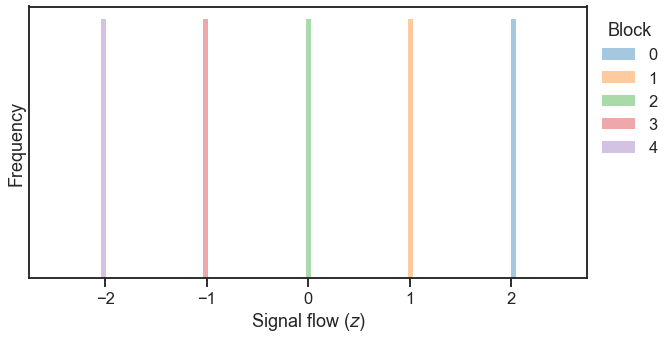

In [6]:
plt.figure(figsize=(10, 5))
for b in range(n_blocks):
    ax = sns.distplot(z[block_labels == b],
                      label=b,
                      kde=False,
                      bins=np.linspace(-2.5,2.5,100),
                      norm_hist=False)
ax.set_xlabel(r"Signal flow ($z$)")
ax.set_yticks(())
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=.5, title="Block");

For this perfect feedforward network, the signal flow of a node in block 0 is exactly 1 greater than the signal flow of the block it projects to, as we hoped it would be. 

### What if the graph wasn't perfectly feedforward?
Here we sample a graph randomly (the first one wasn't really random since the probability of feedforward was 1). We set the projection probability within block to $p=0.2$ and to the next block at $p=0.3$.

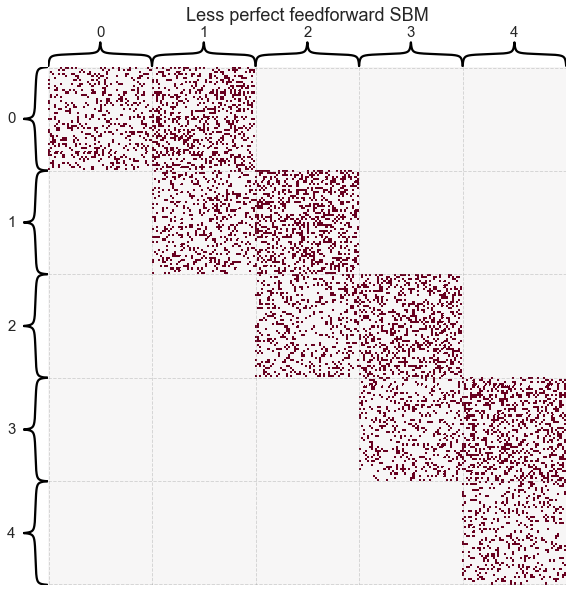

In [7]:
low_p = 0 # probability of random edges anywhere in the graph
diag_p = 0.2 # probability of edges within a block
feedforward_p = 0.3 # probability of edges projecting to the next block

block_probs = get_feedforward_B(low_p,
                                diag_p,
                                feedforward_p,
                                n_blocks=n_blocks)
A = sbm(block_sizes, block_probs, directed=True, loops=False)
heatmap(A,
        cbar=False,
        title="Less perfect feedforward SBM",
        inner_hier_labels=block_labels, 
        hier_label_fontsize=15);

Let's turn our signal flow calculation into an actual function, and use it on the graph above. 

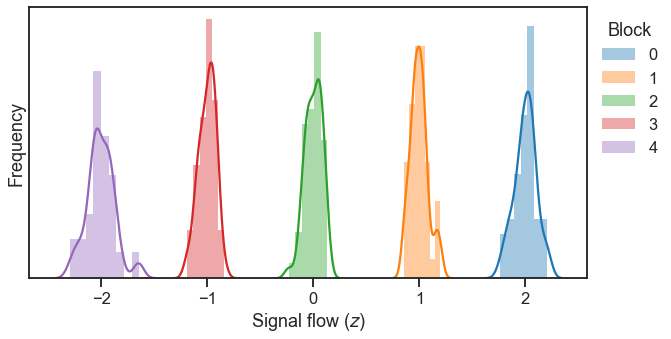

In [8]:
def calc_signal_flow(A):
    W = (A + A.T) / 2

    D = np.diag(np.sum(W, axis=1))

    L = D - W

    b = np.sum(W * np.sign(A - A.T), axis=1)
    L_dagger = np.linalg.pinv(L) # this is the Moore-Penrose inverse
    z = L_dagger @ b
    
    return z

z = calc_signal_flow(A)

plt.figure(figsize=(10, 5))
for b in range(n_blocks):
    ax = sns.distplot(z[block_labels == b], label=b)
ax.set_xlabel(r"Signal flow ($z$)")
ax.set_yticks(())
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=.5, title="Block");

### What if we start to add noise to the feedforward pattern?
Here we keep the probability within block the same, as well as
the feedforward probability, but let any two nodes connect with 
probability $p = 0.05$. 

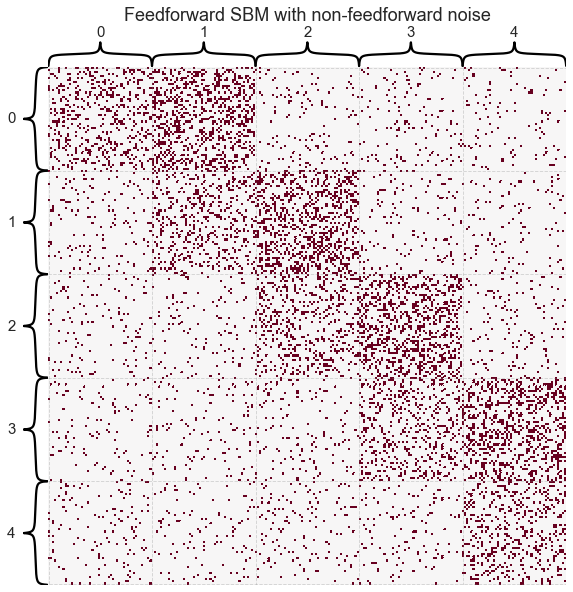

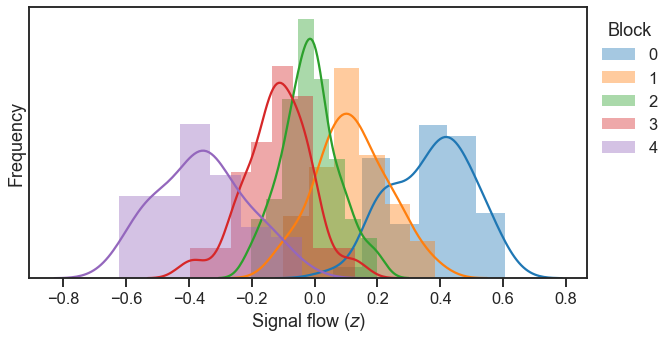

In [9]:
low_p = 0.05 # probability of random edges anywhere in the graph
diag_p = 0.2 # probability of edges within a block
feedforward_p = 0.3 # probability of edges projecting to the next block

block_probs = get_feedforward_B(low_p,
                                diag_p,
                                feedforward_p,
                                n_blocks=n_blocks)
A = sbm(block_sizes, block_probs, directed=True, loops=False)
heatmap(A,
        cbar=False,
        title="Feedforward SBM with non-feedforward noise",
        inner_hier_labels=block_labels, 
        hier_label_fontsize=15);

z = calc_signal_flow(A)

plt.figure(figsize=(10, 5))
for b in range(n_blocks):
    ax = sns.distplot(z[block_labels == b], label=b)
ax.set_xlabel(r"Signal flow ($z$)")
ax.set_yticks(())
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=.5, title="Block");

### But what if we had more data?
Let's make each block 10x bigger

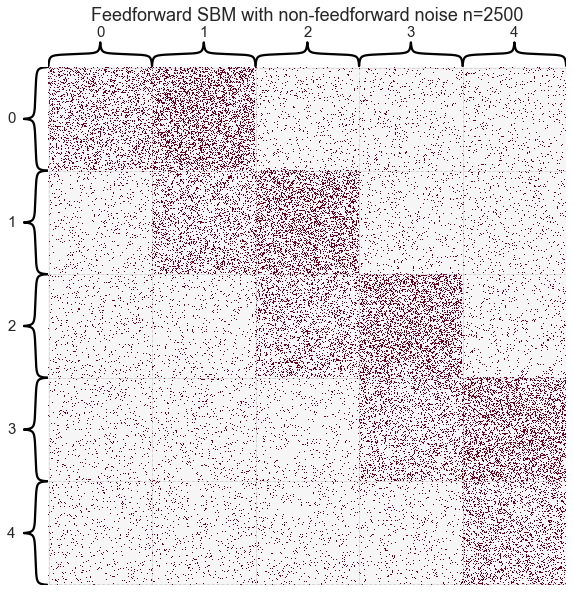

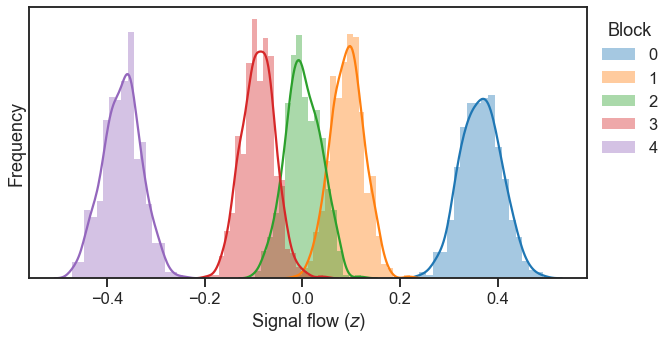

In [10]:
n_per_block = 500
block_sizes = n_blocks*[n_per_block]
n_verts = sum(block_sizes)
block_labels = get_block_labels(block_sizes)

low_p = 0.05 # probability of random edges anywhere in the graph
diag_p = 0.2 # probability of edges within a block
feedforward_p = 0.3 # probability of edges projecting to the next block

block_probs = get_feedforward_B(low_p,
                                diag_p,
                                feedforward_p,
                                n_blocks=n_blocks)
A = sbm(block_sizes, block_probs, directed=True, loops=False)
heatmap(A,
        cbar=False,
        title=f"Feedforward SBM with non-feedforward noise n={n_verts}",
        inner_hier_labels=block_labels, 
        hier_label_fontsize=15);

z = calc_signal_flow(A)

plt.figure(figsize=(10, 5))
for b in range(n_blocks):
    ax = sns.distplot(z[block_labels == b], label=b)
ax.set_xlabel(r"Signal flow ($z$)")
ax.set_yticks(())
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=.5, title="Block");

### How does this look with more blocks?

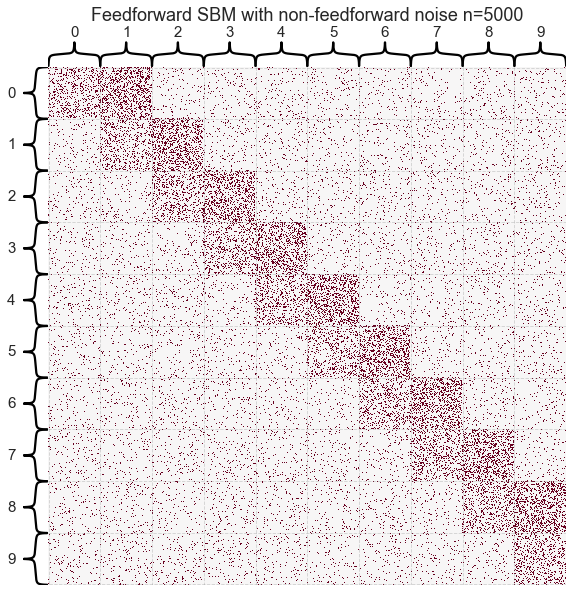

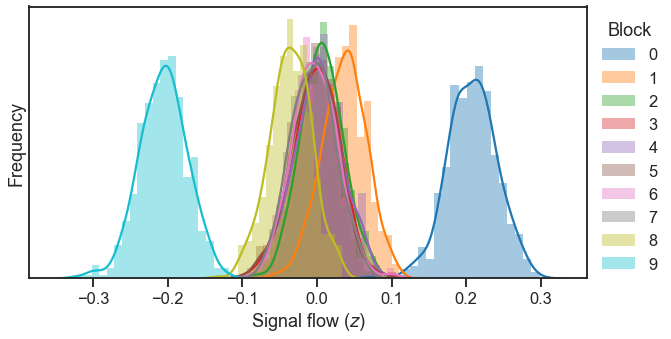

In [11]:
n_per_block = 500
n_blocks = 10
block_sizes = n_blocks*[n_per_block]
n_verts = sum(block_sizes)
block_labels = get_block_labels(block_sizes)

low_p = 0.05 # probability of random edges anywhere in the graph
diag_p = 0.2 # probability of edges within a block
feedforward_p = 0.3 # probability of edges projecting to the next block

block_probs = get_feedforward_B(low_p,
                                diag_p,
                                feedforward_p,
                                n_blocks=n_blocks)
A = sbm(block_sizes, block_probs, directed=True, loops=False)
heatmap(A,
        cbar=False,
        title=f"Feedforward SBM with non-feedforward noise n={n_verts}",
        inner_hier_labels=block_labels, 
        hier_label_fontsize=15);

z = calc_signal_flow(A)

plt.figure(figsize=(10, 5))
for b in range(n_blocks):
    ax = sns.distplot(z[block_labels == b], label=b)
ax.set_xlabel(r"Signal flow ($z$)")
ax.set_yticks(())
ax.set_ylabel("Frequency")
ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=.5, title="Block");

It appears that the first and last block as clearly being separated in signal flow, and somewhat more so for blocks 1 and 8 (which are second from first and second from last in the feedforward path, respectively). I need to investigate how to get separable Gaussians like we had before as the number of blocks in the feedforward pathway grows, and the "off-feedforward" noise is modest.

### References
[1] Varshney, Lav R., et al. "Structural properties of the Caenorhabditis elegans neuronal network." PLoS computational biology 7.2 (2011): e1001066.

[2] Carmel, Liran, David Harel, and Yehuda Koren. "Combining hierarchy and energy for drawing directed graphs." IEEE Transactions on Visualization and Computer Graphics 10.1 (2004): 46-57.

[3] Von Luxburg, Ulrike. "A tutorial on spectral clustering." Statistics and computing 17.4 (2007): 395-416.